# Machine Learning Mini Project 3
### Richard Campo in collaboration with Julia Klauss

## Data Analysis

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### (1.)

In [96]:
variable_names = pd.read_excel("PPHA_30546_MP03-Variable_Description.xlsx")

data = pd.read_csv("Data-Covid002.csv", encoding='latin1')

var_names = variable_names["Variable"].tolist()

selected_columns = var_names + ["county", "state"]

clean_data = data.loc[:, selected_columns]

### (2.)

In [97]:
print(clean_data.describe())

            casespc     deathspc  intersects_msa  cur_smoke_q1  cur_smoke_q2  \
count   3107.000000  3107.000000     3107.000000   3107.000000   3107.000000   
mean     577.600881    23.790131        0.596717      0.212659      0.171048   
std     1237.223012    67.852145        0.490636      0.149348      0.128130   
min        0.000000     0.000000        0.000000      0.000000      0.000000   
25%      107.026845     0.000000        0.000000      0.000000      0.000000   
50%      249.338040     3.802303        1.000000      0.250000      0.198718   
75%      598.489625    21.461759        1.000000      0.310931      0.250000   
max    31379.596000  2279.610600        1.000000      1.000000      1.000000   

       cur_smoke_q3  cur_smoke_q4  bmi_obese_q1  bmi_obese_q2  bmi_obese_q3  \
count   3107.000000   3107.000000   3107.000000   3107.000000   3107.000000   
mean       0.134467      0.098316      0.239166      0.214580      0.209621   
std        0.132181      0.110110      0.1

### (3.)

In [98]:
clean_data = clean_data.dropna()

### (4.)

In [99]:
state_dummies = pd.get_dummies(clean_data["state"], drop_first=True)

clean_data = pd.concat([clean_data, state_dummies], axis=1)

clean_data = clean_data.drop(["state", "county"], axis=1)

### (5.)

In [100]:
X = clean_data.drop("deathspc", axis=1)
y = clean_data["deathspc"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
    )

### (6.)
#### (a.)

In [101]:
ols = LinearRegression().fit(X_train, y_train)
y_pred_train = ols.predict(X_train)
mse_train_ols = mean_squared_error(y_train, y_pred_train)
print("OLS-Train MSE: ", round(mse_train_ols,2))

OLS-Train MSE:  1137.16


In [102]:
y_pred_test = ols.predict(X_test)
mse_test_ols = mean_squared_error(y_test, y_pred_test)
print("OLS-Test MSE: ", round(mse_test_ols,2))

OLS-Test MSE:  1754.88


#### (b.)
We might be concerned about a standard OLS regression overfitting the data because we have a relatively large number of predictors (63) compared with our number of rows (3,107), and some of the predictors may be correlated with deaths per capita simply by chance. Since these features are not actually very predictive and can be thought of as adding noise, we would like to downweight or remove them from the model so that it can achieve a lower test error rate.

We do have some evidence of overfitting since our model's error on the training set is a good deal lower than the error on the test set. Removing or downweighting unhelpful predictors has a good chance of improving our model's fit.

### (7.) Ridge Regressions
#### (a.)

In [111]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ridge = Ridge()

alpha_param = np.power(10, (np.linspace(2.5, 2.75, 100)))

# From lab
def vector_values(grid_search, trials):
    '''
    Extracts mean and standard deviation scores from a GridSearchCV object.
    ​
    Parameters
    ----------
    grid_search : GridSearchCV object
    The result of a grid search performed using scikit-learn's GridSearchCV 
    method.
    trials : int
    The number of trials performed during the grid search.
    ​
    Returns
    -------
    mean_vec : ndarray of shape (trials,)
    Array of mean scores, with the negative of each score stored in the array.
    std_vec : ndarray of shape (trials,)
    Array of standard deviation scores.
    '''
    mean_vec = np.zeros(trials)
    std_vec = np.zeros(trials)
    i = 0
    final = grid_search.cv_results_
    
    means_sds = zip(final["mean_test_score"], final["std_test_score"])

    for mean_score, std_score in means_sds:
        mean_vec[i] = -mean_score
        std_vec[i] = std_score
        i = i+1
    return mean_vec, std_vec

def highlight_min(data, color='yellow'):
    attr = f'background-color: {color}'
    if data.ndim == 1:  # Series
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    return ''

#Creating a parameters grid
param_grid = [{'alpha': alpha_param}]

#### (b.)

In [112]:
#Running Grid Search over the alpha (regularization) parameter
kf = KFold(n_splits=10, random_state = 25, shuffle=True)
grid_search_ridge = GridSearchCV(
    ridge, param_grid, cv=kf, scoring='neg_mean_squared_error'
    )
grid_search_ridge.fit(X_train, y_train)

# Extract results for all tested alphas
tested_alphas = [
    params['alpha'] for params in grid_search_ridge.cv_results_['params']
    ]

# Assuming vector_values is properly defined to extract mean and standard 
# deviation values
mean_vec_ridge, std_vec_ridge = vector_values(
    grid_search_ridge, len(tested_alphas)
    )
results_cv_ridge = pd.DataFrame(
    {'alpha': tested_alphas, 'MSE': mean_vec_ridge}
    )

top_5_results_cv_ridge = results_cv_ridge.sort_values(
    by='MSE', ascending=True
    ).head(5)

styled_top_5 = top_5_results_cv_ridge.style.apply(
    highlight_min, subset=['MSE']
    )
display(styled_top_5)

,alpha,MSE
60,448.244688,1337.214958
59,445.645883,1337.215057
61,450.858648,1337.217890
58,443.062146,1337.218166
62,453.487851,1337.223873


After narrowing our search a few times, we find an optimal value of $\lambda$ (also called $\alpha$) of about 448, suggesting that our model was overfitting the data.

#### (c.)

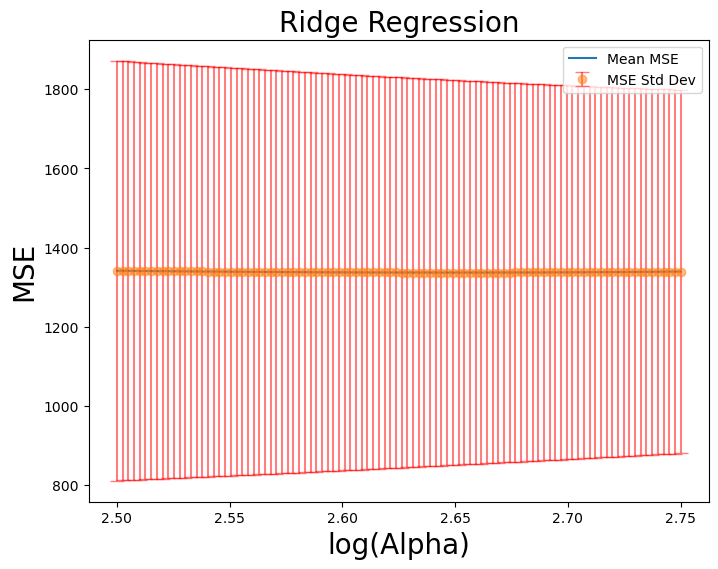

In [115]:
mean_vec, std_vec = vector_values(grid_search_ridge, len(tested_alphas))

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Ridge Regression', fontsize=20)
log_alpha_param = np.log10(alpha_param) # log transform to aid with interpretability of axis
ax.plot(log_alpha_param, mean_vec, label='Mean MSE')
ax.errorbar(log_alpha_param, mean_vec, yerr=std_vec, fmt='o', ecolor='r', capsize=5, alpha=0.5, label='MSE Std Dev')
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("log(Lambda)", fontsize=20)
plt.legend()
plt.show()

It's hard to tell from the graph above since we're so zoomed in, but we found that MSE is minimzed when $\lambda/\alpha$ equals about 448, which corresponds to about $10^{2.651}$, or 2.651 on the x-axis above. Since the error rate on the training data is about the same for many different values of $\lambda/\alpha$ though, it likely would not matter too much which value we picked in the range we've narrowed it down to.

#### (d.)

We found an optimal $\lambda/\alpha$ of about 448, or about $10^{2.651}$

#### (e.)

In [117]:
ridge_final = Ridge(alpha=448).fit(X_train, y_train)

y_pred_train_ridge = ridge_final.predict(X_train)

mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
print("Ridge-Train MSE: ", round(mse_train_ridge,2))

Ridge-Train MSE:  1183.91


In [119]:
y_pred_test_ridge = ridge_final.predict(X_test)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
print("Ridge-Test MSE: ", round(mse_test_ridge,2))

Ridge-Test MSE:  1820.15


Interestingly, Ridge Regression's test MSE is higher than the MSE we calculated using OLS, despite using the optimal non-zero value of $\lambda/\alpha$ we found using GridSearchCV(). This suggests that we may have an unrepresentative test set from when we split our data into training and test sets. We would probably want to use 5FCV or 10FCV to get a more accurate estimate of the test error.

### (7.) Lasso
#### (a.)